#### In this Notebook, I had implemented the anomaly detection model to predict whether the energy usage in a building is anomalous or not. This will help to save a lot of energy.

In [31]:
# import libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import cufflinks as cf
# cf.set_config_file(offline=True)
# Input data files are available i

import datetime

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [32]:
data15 = pd.read_csv('15_builds_dataset.csv')
data15.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,91,2016-01-01 00:00:00,NaN,0,0,Education,68094,103,0,19.4,...,4.116,3.981,4.146,4.12,4.801,4.489,4.079,4.324,4.808,4.461
1,439,2016-01-01 00:00:00,55.93,0,3,Office,62205,255,0,7.2,...,4.116,3.981,4.146,4.12,4.620,4.211,3.854,4.320,4.670,4.410
2,693,2016-01-01 00:00:00,NaN,0,5,Office,57436,76,3,-29.9,...,4.116,3.981,4.146,4.12,4.533,4.211,2.670,4.207,4.635,4.535
3,884,2016-01-01 00:00:00,NaN,0,9,Education,38598,255,0,9.4,...,4.116,3.981,4.146,4.12,3.933,4.489,4.548,3.630,3.962,3.876
4,896,2016-01-01 00:00:00,NaN,0,9,Education,245637,255,0,9.4,...,4.116,3.981,4.146,4.12,5.541,4.489,4.548,5.295,5.541,5.492


In [33]:
data15.columns

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

#### We have been provided with a whole lot of features. As per the Author of the data one can focused on the model building but till we are not sure with the features provided and what they represent how can we go forward.

In [34]:
data15.shape

(131623, 57)

In [35]:
print(data15['anomaly'].unique())
print(data15['anomaly'].nunique())

[0 1]
2


In [36]:
for col in data15.columns:
    k = data15[col].isnull().sum()
    if k > 0:
        print(f'{col} : {k}')

meter_reading : 8741


#### In this data only meter_reading has null values

In [37]:
data15[data15['anomaly']==1].isnull().sum()

building_id                      0
timestamp                        0
meter_reading                    0
anomaly                          0
site_id                          0
primary_use                      0
square_feet                      0
year_built                       0
floor_count                      0
air_temperature                  0
cloud_coverage                   0
dew_temperature                  0
precip_depth_1_hr                0
sea_level_pressure               0
wind_direction                   0
wind_speed                       0
air_temperature_mean_lag7        0
air_temperature_max_lag7         0
air_temperature_min_lag7         0
air_temperature_std_lag7         0
air_temperature_mean_lag73       0
air_temperature_max_lag73        0
air_temperature_min_lag73        0
air_temperature_std_lag73        0
hour                             0
weekday                          0
month                            0
year                             0
weekday_hour        

#### There are no such entries where it is an anomalous case and meter_reading is null.

In [38]:
data15[data15['meter_reading']==1.0]['anomaly'].value_counts()

anomaly
1    1136
Name: count, dtype: int64

In [39]:
for idx in tqdm(data15['building_id'].unique()):
    if data15[data15['building_id']==idx]['primary_use'].nunique()>1:
        print(idx)

100%|██████████| 15/15 [00:00<00:00, 332.27it/s]


#### Meter reading appears the most significant of all features. For viz. purpose, a density plot (credits.- @headsortails ) is what I feel provides a great intuition on why it's a significant driver.

#### The spike at 0 is what's creating a strong separation. Almost 45% of all anomalies have a log(meter reading) = 0. Also, of all readings with log(meter_reading) = 0, ~100% are anomalous.

In [40]:
print(data15['meter_reading'].dtype)

print(data15['meter_reading'].isnull().sum())

print(data15['meter_reading'].head())


float64
8741
0      NaN
1    55.93
2      NaN
3      NaN
4      NaN
Name: meter_reading, dtype: float64


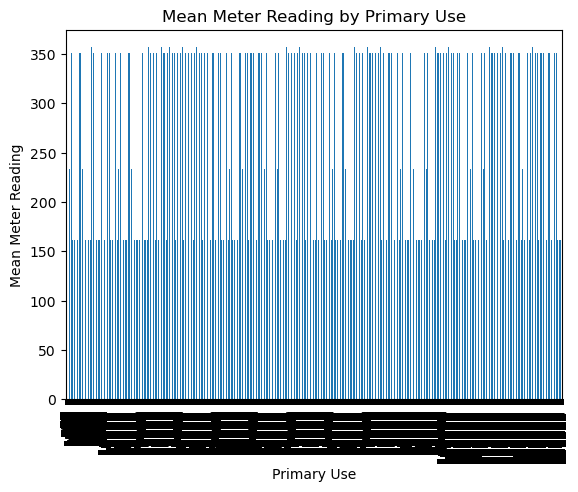

In [41]:
mean_by_use = data15.groupby('primary_use')['meter_reading'].transform('mean')
mean_by_use.plot.bar()
plt.xlabel('Primary Use')
plt.ylabel('Mean Meter Reading')
plt.title('Mean Meter Reading by Primary Use')
plt.show()

#### Each building provides only one type of facility/usecase and above chart shows the mean usage by use case throughout the year with minimum at the religious places and highest at the Education institutions.


In [42]:
ints = []
objects = []
floats = []

for col in data15.columns:
    if data15[col].dtype == int:
        ints.append(col)
    elif data15[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

#### Analysis of the columns with int datatype.


In [43]:
ints

['building_id',
 'anomaly',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'cloud_coverage',
 'precip_depth_1_hr',
 'wind_direction',
 'hour',
 'weekday',
 'month',
 'year',
 'is_holiday']

#### Columns from hour to is_holiday is nothing but the expanded form of the timestamp so, we can remove that feature.

In [44]:
data15[ints].nunique()

building_id          15
anomaly               2
site_id               6
square_feet          15
year_built            3
floor_count           2
cloud_coverage        7
precip_depth_1_hr    94
wind_direction       39
hour                 24
weekday               7
month                12
year                  1
is_holiday            2
dtype: int64

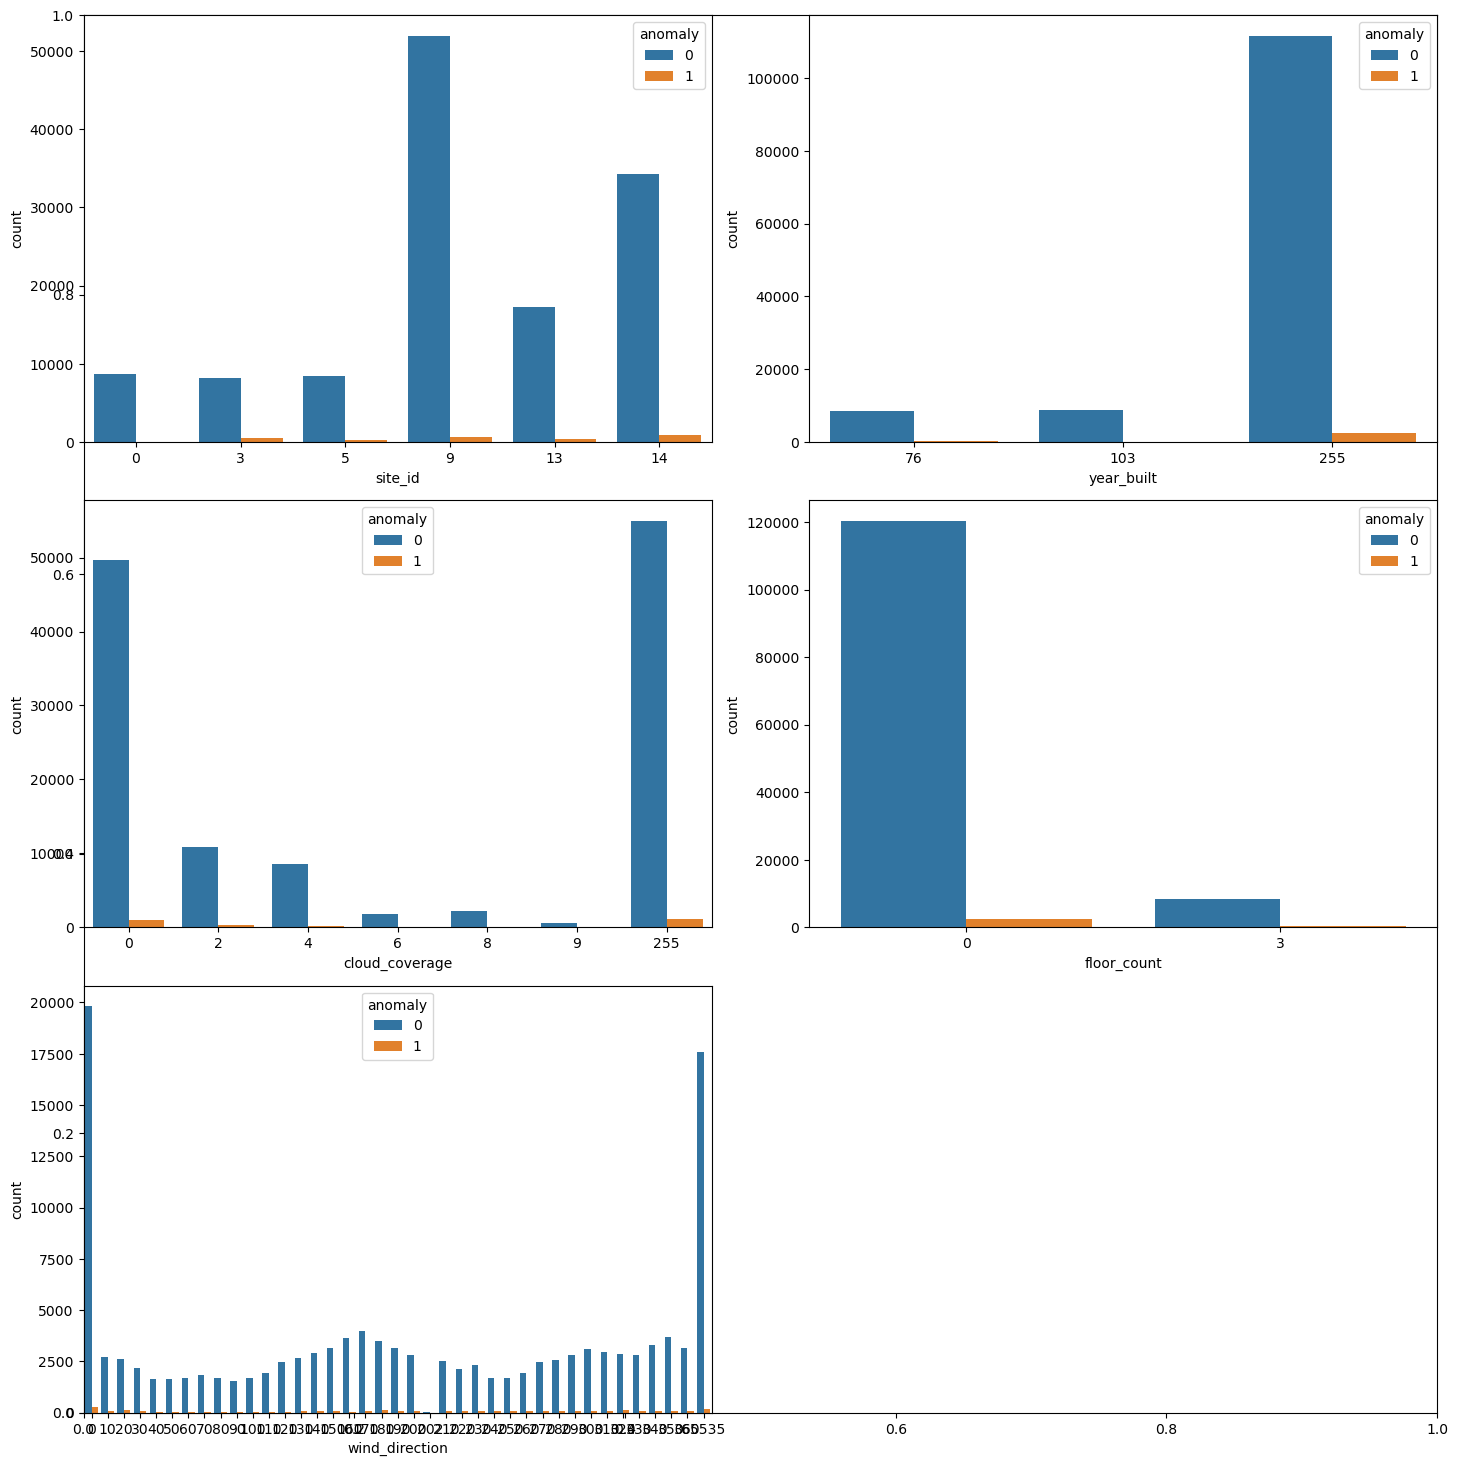

In [45]:
plt.subplots(figsize=(15,15))
sample = ['site_id', 'year_built', 'cloud_coverage', 'floor_count', 'wind_direction']

for i, col in enumerate(sample):
    plt.subplot(3,2,i+1)
    sb.countplot(data=data15, x=col, hue='anomaly')
plt.tight_layout()
plt.show()


In [46]:
data15['year_built'].value_counts()

year_built
255    114055
103      8784
76       8784
Name: count, dtype: int64

In [47]:
data15['cloud_coverage'].value_counts()

cloud_coverage
255    56112
0      50687
2      11185
4       8765
8       2303
6       1921
9        650
Name: count, dtype: int64

#### year_built - To get the exact year_built add 1900 to the same

#### cloud_coverage - It has all values from 0 - 9. But the value 255 in both year_built and cloud_coverage are replacement for the null values.

In [48]:
data15['cloud_coverage'] = data15['cloud_coverage'].replace({255:10})
data15.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,91,2016-01-01 00:00:00,NaN,0,0,Education,68094,103,0,19.4,...,4.116,3.981,4.146,4.12,4.801,4.489,4.079,4.324,4.808,4.461
1,439,2016-01-01 00:00:00,55.93,0,3,Office,62205,255,0,7.2,...,4.116,3.981,4.146,4.12,4.620,4.211,3.854,4.320,4.670,4.410
2,693,2016-01-01 00:00:00,NaN,0,5,Office,57436,76,3,-29.9,...,4.116,3.981,4.146,4.12,4.533,4.211,2.670,4.207,4.635,4.535
3,884,2016-01-01 00:00:00,NaN,0,9,Education,38598,255,0,9.4,...,4.116,3.981,4.146,4.12,3.933,4.489,4.548,3.630,3.962,3.876
4,896,2016-01-01 00:00:00,NaN,0,9,Education,245637,255,0,9.4,...,4.116,3.981,4.146,4.12,5.541,4.489,4.548,5.295,5.541,5.492


In [49]:
for col in data15.columns:
    if data15[col].nunique()==1:
        print(col, data15[col].dtype)

year int64
gte_meter float64


In [50]:
for shift_hours in tqdm([-1,1,-24,24,-7*24,7*24]):
    meter_reading_shift = data15[['building_id', 'timestamp', 'meter_reading']]
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    data15 = data15.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    
    data15['lag_value_'+str(shift_hours)] = data15['lag_value_'+str(shift_hours)]-data15['meter_reading']

100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


#### No use of columns in the modelling with only one values for all the entries.

In [51]:
data15 = data15.drop(['timestamp', 'year', 'gte_meter'], axis=1)

#### Analysis of the columns with object datatype.

In [52]:
objects

['timestamp',
 'primary_use',
 'weekday_hour',
 'building_weekday_hour',
 'building_weekday',
 'building_month',
 'building_hour',
 'building_meter']

In [53]:
data15['building_month'].unique()

array(['91-0-1', '439-0-1', '693-0-1', '884-0-1', '896-0-1', '922-0-1',
       '926-0-1', '945-0-1', '968-0-1', '1172-0-1', '1219-0-1',
       '1246-0-1', '1272-0-1', '1284-0-1', '1304-0-1', '91-0-2',
       '439-0-2', '693-0-2', '884-0-2', '896-0-2', '922-0-2', '926-0-2',
       '945-0-2', '968-0-2', '1172-0-2', '1219-0-2', '1246-0-2',
       '1272-0-2', '1284-0-2', '1304-0-2', '91-0-3', '439-0-3', '693-0-3',
       '884-0-3', '896-0-3', '922-0-3', '926-0-3', '945-0-3', '968-0-3',
       '1172-0-3', '1219-0-3', '1246-0-3', '1272-0-3', '1284-0-3',
       '1304-0-3', '91-0-4', '439-0-4', '693-0-4', '884-0-4', '896-0-4',
       '922-0-4', '926-0-4', '945-0-4', '968-0-4', '1172-0-4', '1219-0-4',
       '1246-0-4', '1272-0-4', '1284-0-4', '1304-0-4', '91-0-5',
       '439-0-5', '693-0-5', '884-0-5', '896-0-5', '922-0-5', '926-0-5',
       '945-0-5', '968-0-5', '1172-0-5', '1219-0-5', '1246-0-5',
       '1272-0-5', '1284-0-5', '1304-0-5', '91-0-6', '439-0-6', '693-0-6',
       '884-0-6', '8

#### It seems like these features are nothing but the concatenation of the building_id with the month, hour or other time realted features. In my opinion these are not going to help us as none of the values will overlap with the test data as the building id's are totally different for the test data set. So, the distribution of the data will vary.


In [54]:
data15 = data15.drop(objects[2:], axis=1)
print(data15.shape)

(131623, 54)


#### Analysis of the columns with float datatype.


In [55]:
floats

['meter_reading',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7',
 'air_temperature_std_lag7',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_std_lag73',
 'hour_x',
 'hour_y',
 'month_x',
 'month_y',
 'weekday_x',
 'weekday_y',
 'gte_hour',
 'gte_weekday',
 'gte_month',
 'gte_building_id',
 'gte_primary_use',
 'gte_site_id',
 'gte_meter',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month']

#### These features from it's name seems like they are derived by feature engineering from the time and the building_id except for some columns let's keep them as of now. It has been given in the data section that these features has been used by the winners so, may be these features proved to be helpful.

In [56]:
def impute_nulls(data):
    mean_reading = data.groupby('building_id')['meter_reading'].transform('mean')
    data['meter_reading'] = data['meter_reading'].fillna(mean_reading)
    return data

train = impute_nulls(data15)

In [57]:
data15.columns

Index(['building_id', 'meter_reading', 'anomaly', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed',
       'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'weekday_x', 'weekday_y', 'is_holiday', 'gte_hour', 'gte_weekday',
       'gte_month', 'gte_building_id', 'gte_primary_use', 'gte_site_id',
       'gte_meter_hour', 'gte_meter_weekday', 'gte_meter_month',
       'gte_meter_building_id', 'gte_meter_primary_use', 'gte_meter_site_id',
       'gte_meter_building_id_hour', 'gte_meter_building_id_weekday',
       'gte_meter_building_id_mon

#### By the name of the columns it is clear that they have been derived by combining two or more succint features. In such cases there is possibility of having high correlation between the developed feature and the original feature. And as much as I know highly correlated features doesn't help model.

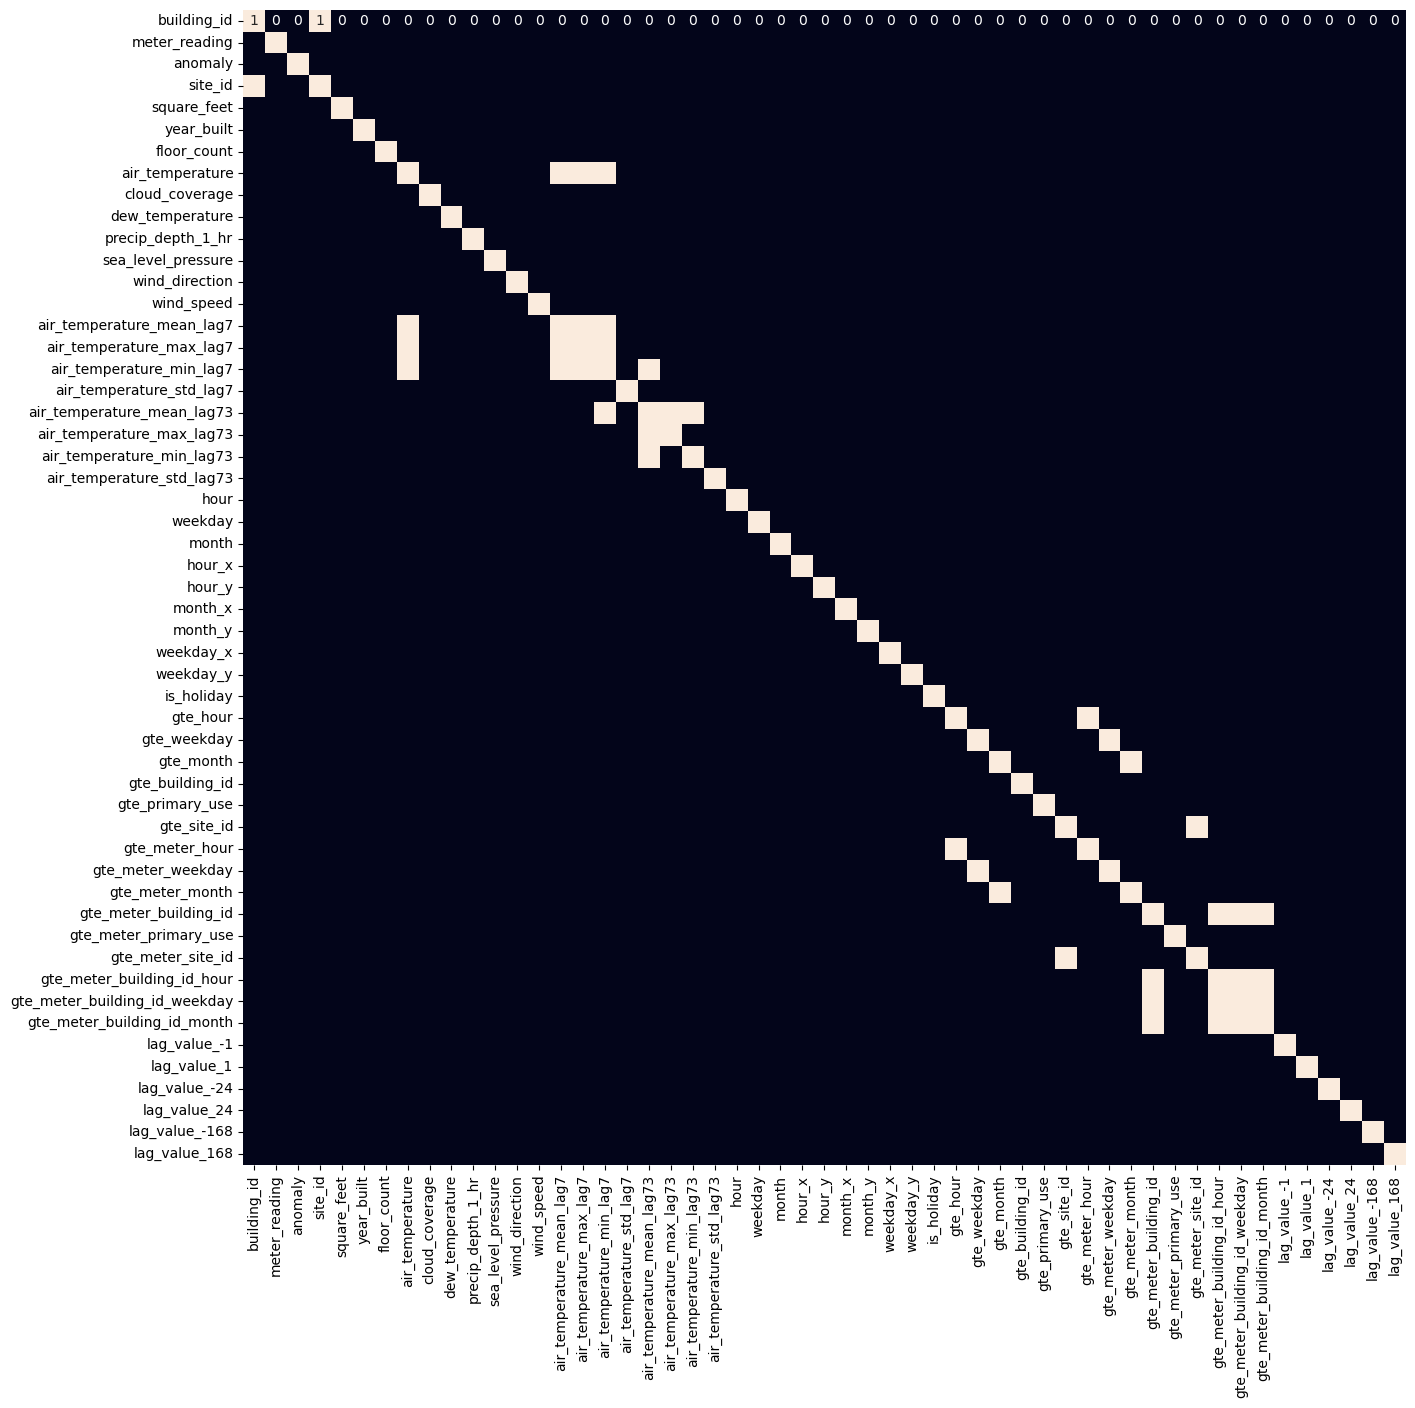

In [58]:
# Assuming df is your dataframe
numerical_columns = data15.select_dtypes(include=['int', 'float']).columns

plt.figure(figsize=(15,15))
sb.heatmap(data15[numerical_columns].corr() > 0.95, annot=True, cbar=False)
plt.show()

In [59]:
hcorr = [ 'building_id',
         'site_id',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7']

data15 = data15.drop(hcorr, axis=1)
data15.shape


(131623, 37)

#### Now, there are no highly correlated features and we are good to go and build our anomaly detection model.

#### Training an XGBClassifier on millions of rows take hell lot of time that is why I have implemented a neural network model so, that the model can go through all the examples in feasible time. By using the RandomOverSampler I had balanced the negative and the positive exmaples so, that model can perform well for the negative as well as positive examples.

In [60]:
# data15 = impute_nulls(data15)
# data15['cloud_coverage'] = data15['cloud_coverage'].replace({255:10})
# data15 = data15.drop(['timestamp', 'year', 'gte_meter'] + objects[2:] + hcorr, axis=1)
data15.shape


(131623, 37)

In [62]:
neg = data15[data15['anomaly'] == 0]
pos = data15[data15['anomaly'] == 1]

print(neg.shape, pos.shape)
negs1 = neg.sample(n = 37296, random_state=10)
negs2 = neg.sample(n = 37296, random_state=20)
df_eq = pd.concat([negs1, pos, negs2, pos], axis=0)
print(df_eq.shape)

(128834, 37) (2789, 37)
(80170, 37)


In [63]:
label_encoder = LabelEncoder()
df_eq['primary_use'] = label_encoder.fit_transform(df_eq['primary_use'])

In [64]:
# X contains all columns except the target variable column

features = df_eq.drop(['anomaly'], axis=1)
target = df_eq['anomaly']

print("Features (X):")
print(features.head())

print("\nTarget Variable (y):")
print(target.head())


Features (X):
        meter_reading  primary_use  square_feet  year_built  floor_count  \
482            81.200            2        57436          76            3   
91116         206.733            1        63847         255            0   
114243         51.510            2        62205         255            0   
77213          57.000            2        50327         255            0   
46078         201.000            0       245637         255            0   

        air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
482                10.0              10              9.0                 -2   
91116              17.8               2              9.4                  0   
114243             13.9               0              2.8                  0   
77213              22.8              10             16.7                  0   
46078              20.6              10             17.8                  0   

        sea_level_pressure  ...  gte_month  gte_buildi

In [65]:
# Assuming df is your dataframe
numerical_columns_not = data15.select_dtypes(exclude=['int', 'float']).columns
numerical_columns_not

Index(['primary_use'], dtype='object')

In [66]:
# Split the data into training and testing sets
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.01, random_state=10)
print(X_train.shape, X_val.shape)

(79368, 36) (802, 36)


In [67]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [68]:
models = [LogisticRegression(), XGBClassifier()]

for i in range(2):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, models[i].predict_proba(X_val)[:,1]))
    print()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

#### As compare to the model which I build by just using the train.csv I achieved around 95% validation accuracy and now 99% which means that the presence of the extra features has certainly helped to improve the performance of the model.

In [70]:
predictions = models[1].predict_proba(X_val)[:,1]

In [69]:
models = [XGBClassifier(), lgb.LGBMClassifier()]

for i in range(2):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, models[i].predict_proba(X_val)[:,1]))
    print() 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  1.0

[LightGBM] [Info] Number of positive: 5513, number of negative: 73855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set 

#### The additional features did make a difference here !!